In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from src.data import data as data_utils
from src.ml import model as model_utils
from run import scripts
import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler

torch.manual_seed(2002);

In [4]:
train_dataloader, val_dataloader, test_dataloader = data_utils.dataloaders(name='elephant', x_version=['players','teams'], y_version='score', train_split=0.8, val_split=0.1, test_split=0.1, batch_size=32, engineered=['player','team'])

/Users/sharshe/Documents/TBN/src/data/data.py:345: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(dataloaders_path)


In [5]:
cfg_dict = {
    'name': 'kalman',
    'dataset_name': 'elephant',
    'x_version': 'players',
    'y_version': 'score',
    'batch_size': 32,
    'train_split': 0.8,
    'val_split': 0.1,
    'test_split': 0.1,
    'n_epochs': 50,
    'loss_fn': 'HuberLoss',
    'optimizer': 'Adam',
    'scheduler': 'ReduceLROnPlateau',
    'model': 'HybridModel',
    'd_mod': 32
}

In [6]:
model = model_utils.HybridModel(d_in=[65, 49], d_mod=cfg_dict['d_mod'])

final prediction: model(x)
[[[0.5841318368911743], [0.5773549675941467]], [[0.5841286182403564], [0.5773508548736572]], [[0.5843510627746582], [0.5774443745613098]], [[0.584344744682312], [0.5784401893615723]], [[0.5844078063964844], [0.5776718258857727]], [[0.5844087600708008], [0.5778849124908447]], [[0.5841578245162964], [0.5777463912963867]], [[0.584133505821228], [0.5771474838256836]], [[0.584417998790741], [0.5787795782089233]], [[0.5838831663131714], [0.5778346657752991]], [[0.5841289758682251], [0.5774021744728088]], [[0.5839931964874268], [0.5774670839309692]], [[0.5841541886329651], [0.5772210359573364]], [[0.5843257904052734], [0.5769690275192261]], [[0.5843089818954468], [0.5780758261680603]], [[0.5842914581298828], [0.5775690078735352]]]
actual value: y
[[[0.5852272510528564], [0.5340909361839294]], [[0.6818181872367859], [0.6193181872367859]], [[0.5511363744735718], [0.5056818127632141]], [[0.5227272510528564], [0.4943181872367859]], [[0.5454545617103577], [0.642045438289

/Users/sharshe/Documents/TBN/run/scripts.py:413: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1728928936609/work/aten/src/ATen/native/ReduceOps.cpp:1823.)
  f.write(f"  std: {grad.std():.4f}\n")
/Users/sharshe/Documents/TBN/run/scripts.py:424: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1728928936609/work/aten/src/ATen/native/ReduceOps.cpp:1823.)
  f.write(f"  std: {param.std().item():.4f}\n")


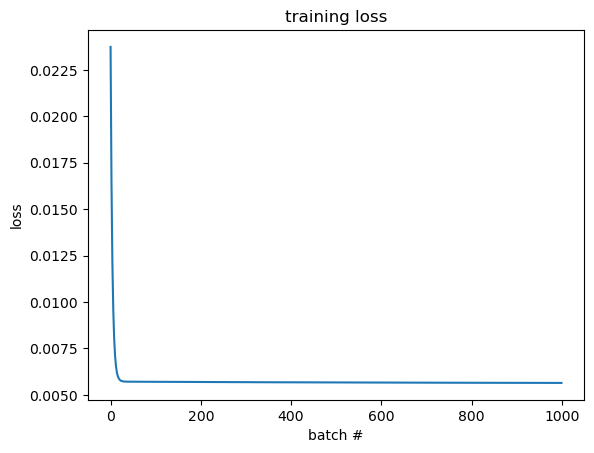

In [7]:
scripts.check_memory(model=model, dataloader=train_dataloader, batch_size=16, n_epochs=1000, lr=3e-4)

In [231]:
optimizer = optim.Adam(model.parameters(), lr=3e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=4)
loss_fn = nn.HuberLoss(delta=0.1)

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


EPOCH 1 OF 100 | jackery | TRAIN MEAN LOSS: 0.003025 | VAL MEAN LOSS: 0.002331
EPOCH 2 OF 100 | jackery | TRAIN MEAN LOSS: 0.002267 | VAL MEAN LOSS: 0.002704
EPOCH 3 OF 100 | jackery | TRAIN MEAN LOSS: 0.002223 | VAL MEAN LOSS: 0.002467
EPOCH 4 OF 100 | jackery | TRAIN MEAN LOSS: 0.002127 | VAL MEAN LOSS: 0.002054
EPOCH 5 OF 100 | jackery | TRAIN MEAN LOSS: 0.002181 | VAL MEAN LOSS: 0.002056
EPOCH 6 OF 100 | jackery | TRAIN MEAN LOSS: 0.002136 | VAL MEAN LOSS: 0.001964
EPOCH 7 OF 100 | jackery | TRAIN MEAN LOSS: 0.002129 | VAL MEAN LOSS: 0.002022
EPOCH 8 OF 100 | jackery | TRAIN MEAN LOSS: 0.002139 | VAL MEAN LOSS: 0.001983
EPOCH 9 OF 100 | jackery | TRAIN MEAN LOSS: 0.002119 | VAL MEAN LOSS: 0.002042
EPOCH 10 OF 100 | jackery | TRAIN MEAN LOSS: 0.002102 | VAL MEAN LOSS: 0.002642
EPOCH 11 OF 100 | jackery | TRAIN MEAN LOSS: 0.002109 | VAL MEAN LOSS: 0.001969
EPOCH 12 OF 100 | jackery | TRAIN MEAN LOSS: 0.002032 | VAL MEAN LOSS: 0.001974
EPOCH 13 OF 100 | jackery | TRAIN MEAN LOSS: 0.00

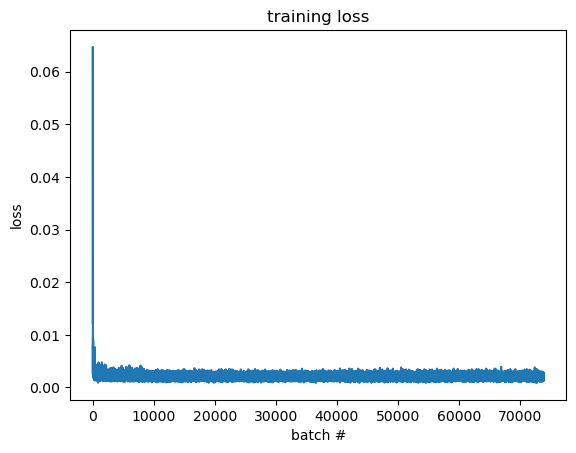

TEST MEAN LOSS: 0.001954
TEST ACCURACY: 0.625254


learning_rate,█████▃▃▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁
test_mean_loss,▁
train_mean_loss,█▅▅▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_loss,▅█▆▂▁▁▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,0.0
test_accuracy,0.62525
test_mean_loss,0.00195
train_mean_loss,0.00199
val_mean_loss,0.00194


In [232]:
scripts.train_test(model=model, train_dataloader=train_dataloader, val_dataloader=val_dataloader, test_dataloader=test_dataloader, cfg_dict=cfg_dict, loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler)